In [1]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [2]:
cosmos_f = open('cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [3]:
# box = sys.argv[1]
# box = 'Box_n50_0_1400'
box = 'Box0_1400'

h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

# LOOKING_AT = [1]
from utils import *


In [4]:
N_data = []
M_data = []
aux_data = []
from scipy.interpolate import interp1d

dlnσinvdMs = {}

vol = -1
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
#     if(a not in LOOKING_AT):
#         continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data += [N_curr]
        M_data += [M_curr]
        aux_data += [{'a':a, 'edge_pair':edge_pair}]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 50) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdM = np.gradient(lnsigmainv, M_numerics)

    dσ2dR = [dsigma2dR(Pk, r) for r in R]
    dRdMs = [dRdM(m_c, box, a) for m_c in M_numerics]
    dlnσinvdM_2 = -1/2 *np.array([a/b*c for (a,b,c) in zip(dσ2dR, sigma2s, dRdMs)])
    
    f_dlnsinvdM_log = interp1d(np.log10(M_numerics), dlnsinvdM,kind='cubic')
    f_dlnsinvdM = lambda x: f_dlnsinvdM_log(np.log10(x))

    dlnσinvdMs[a] = f_dlnsinvdM
    
    f_M = np.logspace(np.log10(np.min(Ms)), np.log10(np.max(Ms)-1),100)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, 20 / R)
/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(dσ2dk, 0, 20 / R)
/home/users/delon/aemulusnu_massfunction/utils.py:100: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit

In [5]:
N_data = np.array(N_data)
print(N_data.shape)
M_data = np.array(M_data)
print(M_data.shape)
aux_data = np.array(aux_data)

(240,)
(240,)


In [6]:
from scipy.special import gamma
from scipy.optimize import curve_fit
from utils import *

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup
# d0 = 2.4
# f1 = 0.12
def tinker(a, M, 
           d0, d1, 
           e0, e1, 
           f0, f1,
           g0, g1,
           log10=False):
    d = p(a, d0, d1,)
    e = p(a, e0, e1,)
    f = p(a, f0, f1,)
    g = p(a, g0, g1,)
    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R)) 
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    if(log10):
        oup *= M*np.log(10)
    return oup/h**4 #h^4 to fix units


In [7]:
from utils import *

a_list = list(NvMs.keys())

from scipy.stats import poisson
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0', 'g1',]
FIXED_VALS = {
# 'd0':d0,
# 'f1':f1,
}

In [8]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [9]:
full_data = []
for a in jackknife:
    if(a_to_z[a]>=2):
        continue
    print(np.shape(jackknife[a][0]))
    full_data += (jackknife[a][0]).tolist()
full_data = np.array(full_data)
full_cov = np.cov(full_data)
print(np.shape(full_cov))

(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(15, 512)
(210, 210)


In [10]:

def log_prior(param_values):
    #uniform prior
    params = dict(zip(param_names, param_values))
    for param in FIXED_VALS:
        params[param] = FIXED_VALS[param]
    for a in a_to_z:
        curr_params = [p(a, params['%s0'%l], params['%s1'%l]) for l in ['d','e','f','g']]
        for curr_param in curr_params:
            if(curr_param< 0 or curr_param>5):
                return -np.inf
    return 0



use_for_fit = np.array([a_to_z[c_aux['a']] < 2.0 for c_aux in aux_data])
# Compute the Poisson errors (assuming counts data)
poisson_err = np.sqrt(N_data[use_for_fit])
poisson_err[poisson_err <1e-10] = 1e-10 #for numerics

print(poisson_err.shape)
def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in a_to_z:
        tinker_eval = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = []
    for (N_curr, c_aux) in zip(N_data[use_for_fit], aux_data[use_for_fit]):
        model_vals += [quad(tinker_fs[c_aux['a']], c_aux['edge_pair'][0], c_aux['edge_pair'][1], epsabs=1e-1)[0]]
        
    assert(len(model_vals) == len(N_data[use_for_fit]))    
        
    # Compute the weighted covariance matrix
    weighted_cov = np.diag(poisson_err**2) + full_cov
    
    # Compute the residuals
    residuals = N_data[use_for_fit] - model_vals
    
    # Compute the chi-square statistic
    inv_weighted_cov = np.linalg.inv(weighted_cov)  # Inverse of the weighted covariance matrix
    chi2 = np.dot(residuals.T, np.dot(inv_weighted_cov, residuals))
    
#     print(weighted_cov)
#     print(np.linalg.det(weighted_cov))
    ret = -0.5 * chi2 #+ np.log(np.linalg.det(weighted_cov))
    
    if not np.isfinite(ret):
        return -np.inf
    
    # Return the log-likelihood
    return ret
    

def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -1e22
    return lp + log_prob(param_values)

(210,)


In [11]:
from utils import *
guess = [ 1.37850024,  0.48741841,  4.40085649, -2.37477071,  0.40872013, -0.52351264,
  0.64074591,  0.82683589]
# while(not np.isfinite(log_likelihood(guess))):
#     guess = np.random.uniform(size=(len(param_names)))

#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="BFGS")
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Box0_1400
     message: Desired error not necessarily achieved due to precision loss.
     success: False
      status: 2
         fun: 36869.87734742822
           x: [ 2.857e-01 -3.332e-01  3.366e+00 -6.511e+00  2.136e+00
               -3.406e+00  5.828e-01 -4.689e-01]
         nit: 49
         jac: [ 2.266e+04 -7.985e+03  1.474e+03  1.546e+03 -7.009e+03
               -7.002e+03 -2.657e+04  7.000e+02]
    hess_inv: [[ 3.080e-07 -6.803e-07 ...  9.782e-07 -1.654e-06]
               [-6.803e-07  1.551e-06 ... -2.183e-06  3.749e-06]
               ...
               [ 9.782e-07 -2.183e-06 ...  3.696e-06 -6.305e-06]
               [-1.654e-06  3.749e-06 ... -6.305e-06  1.130e-05]]
        nfev: 1109
        njev: 121
 param_names: ['d0', 'd1', 'e0', 'e1', 'f0', 'f1', 'g0', 'g1']
[ 0.28571995 -0.33324896  3.36569126 -6.51113429  2.13605975 -3.40572478
  0.58276062 -0.46889899]


/tmp/ipykernel_26118/224879953.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])


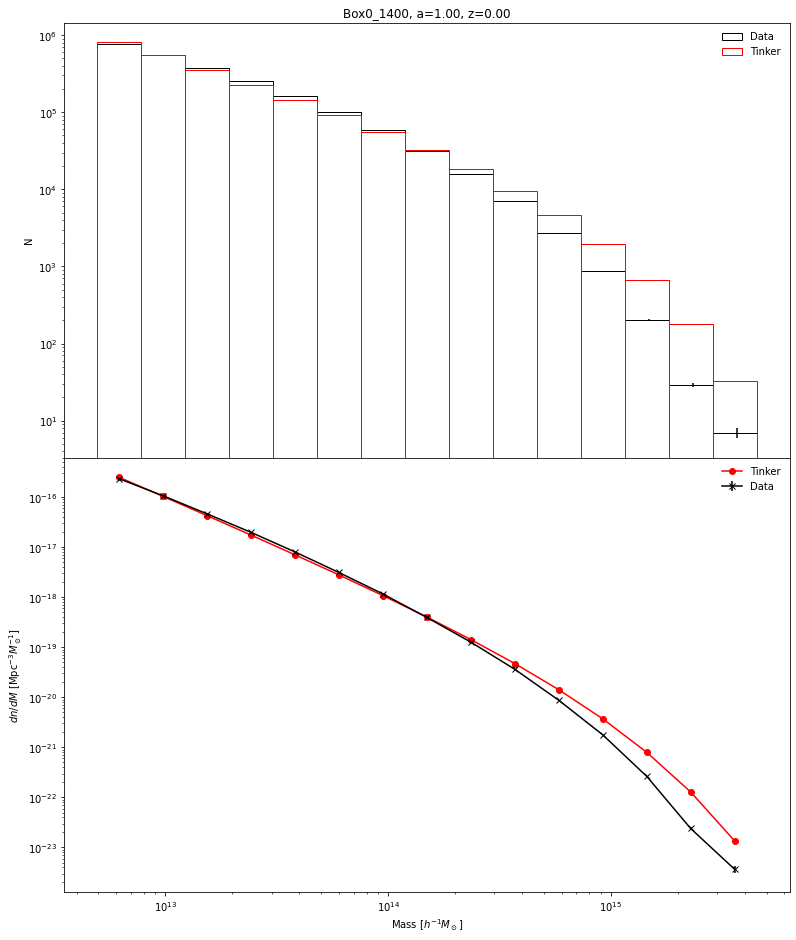

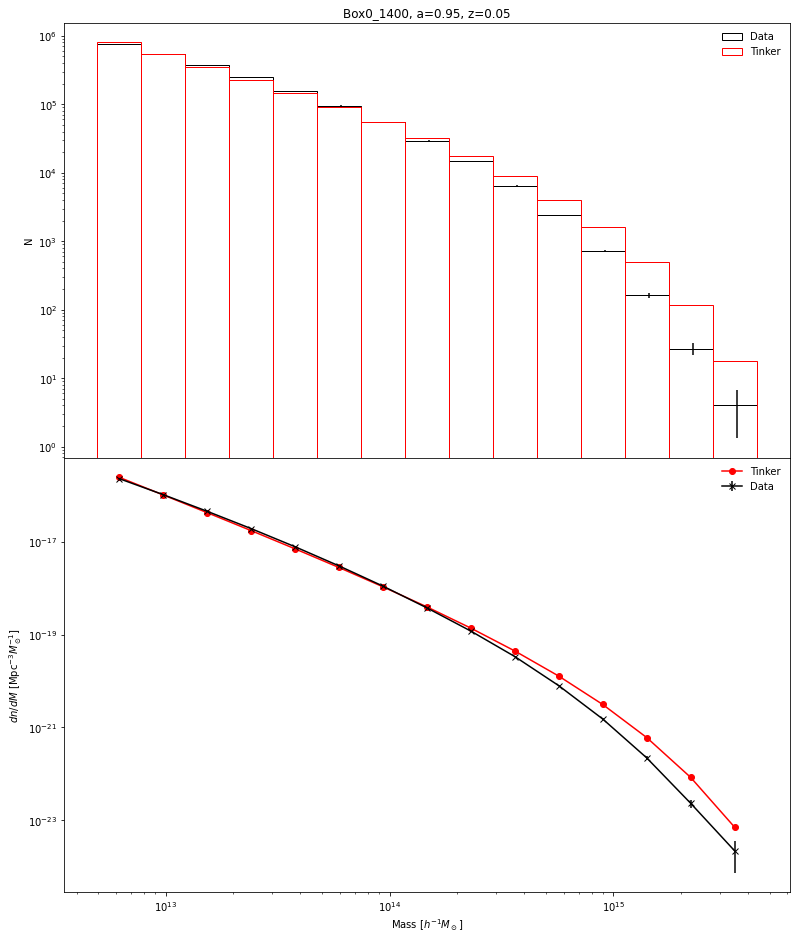

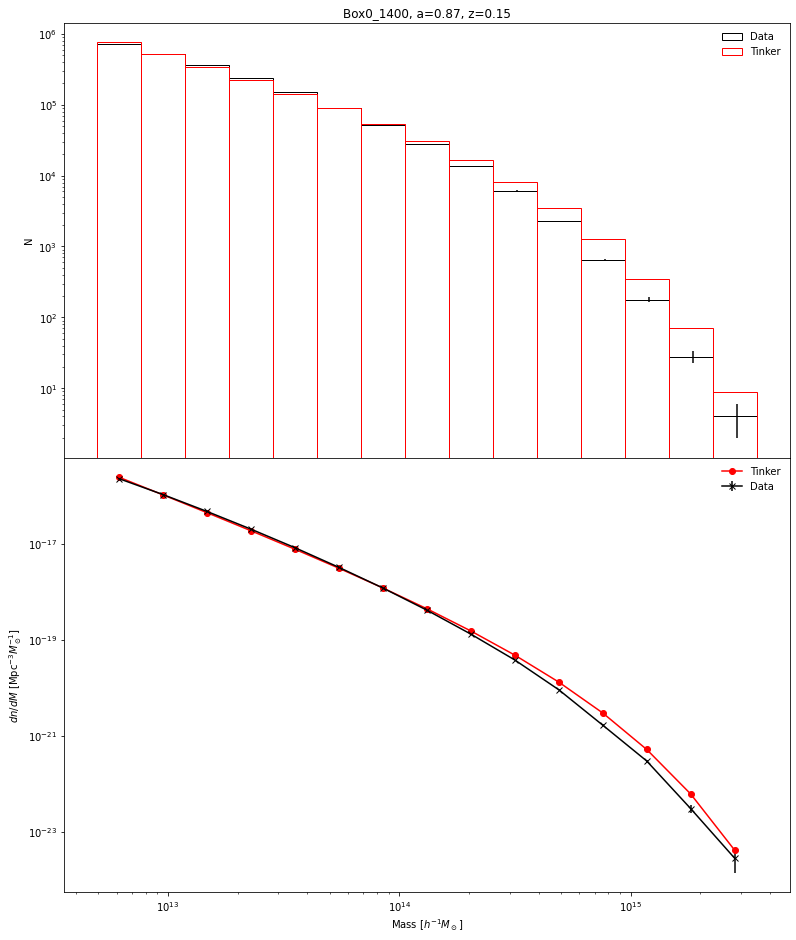

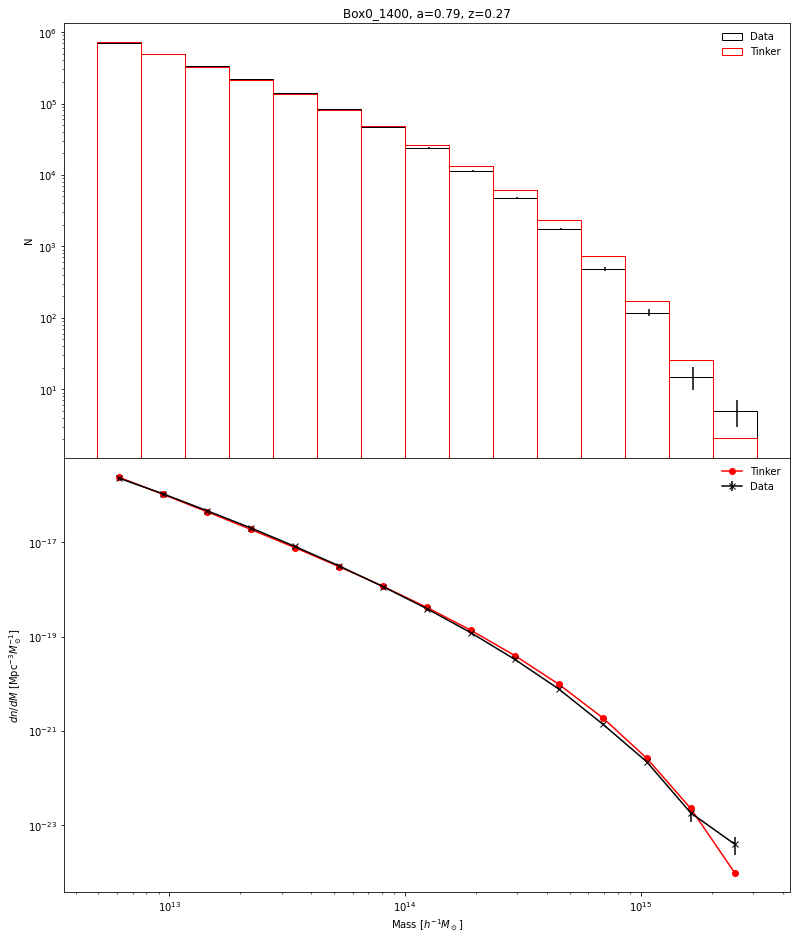

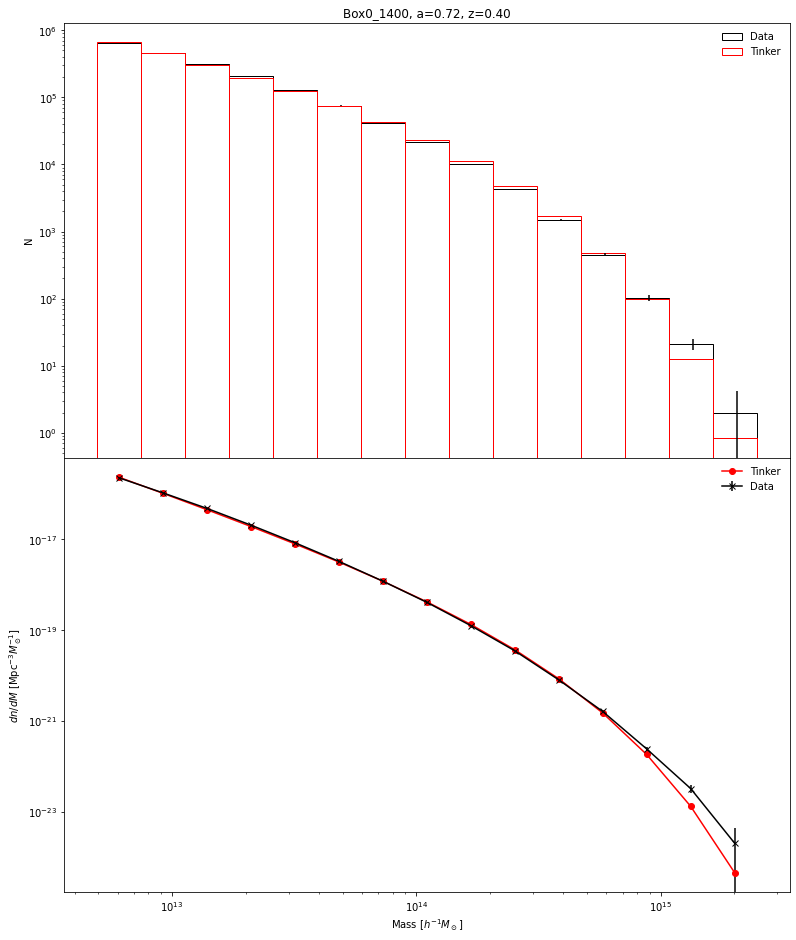

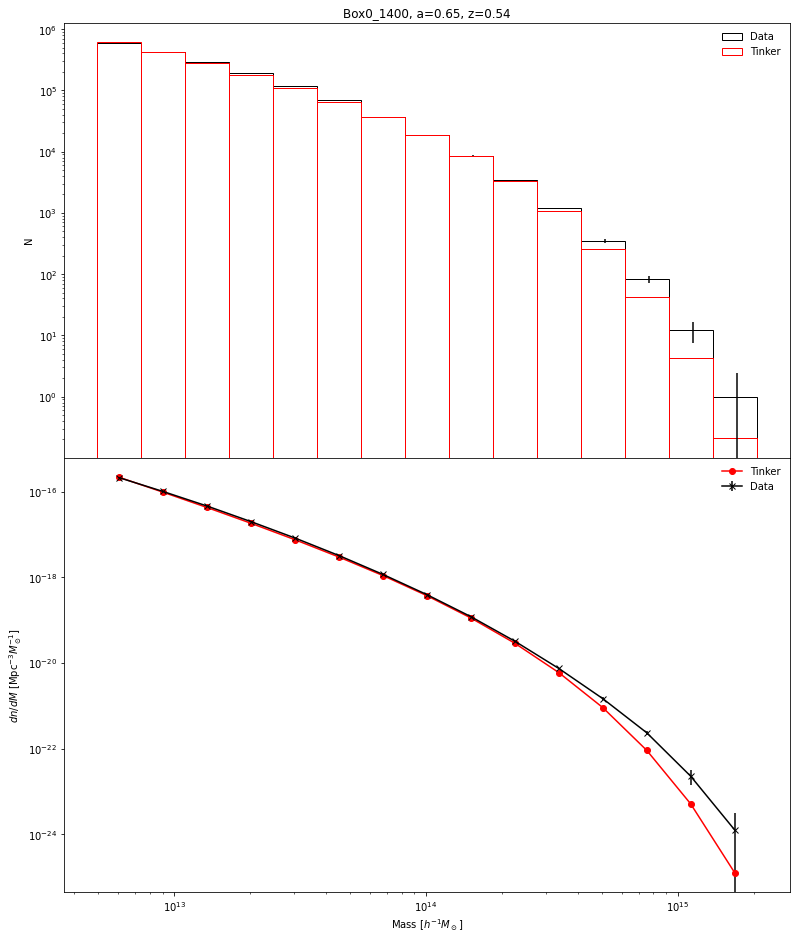

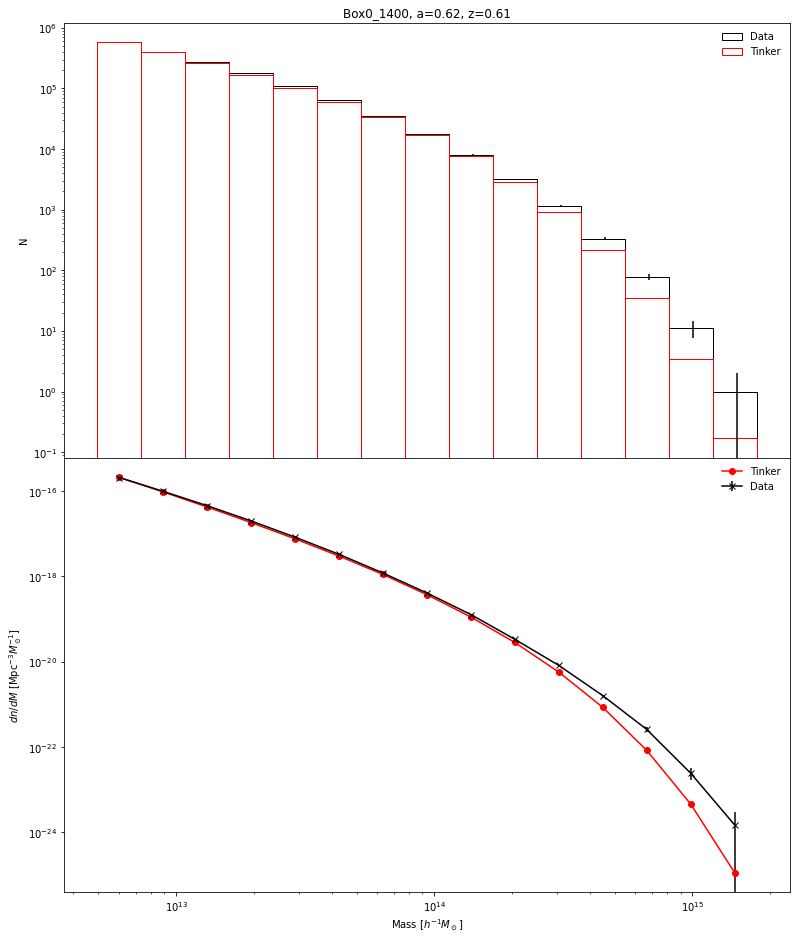

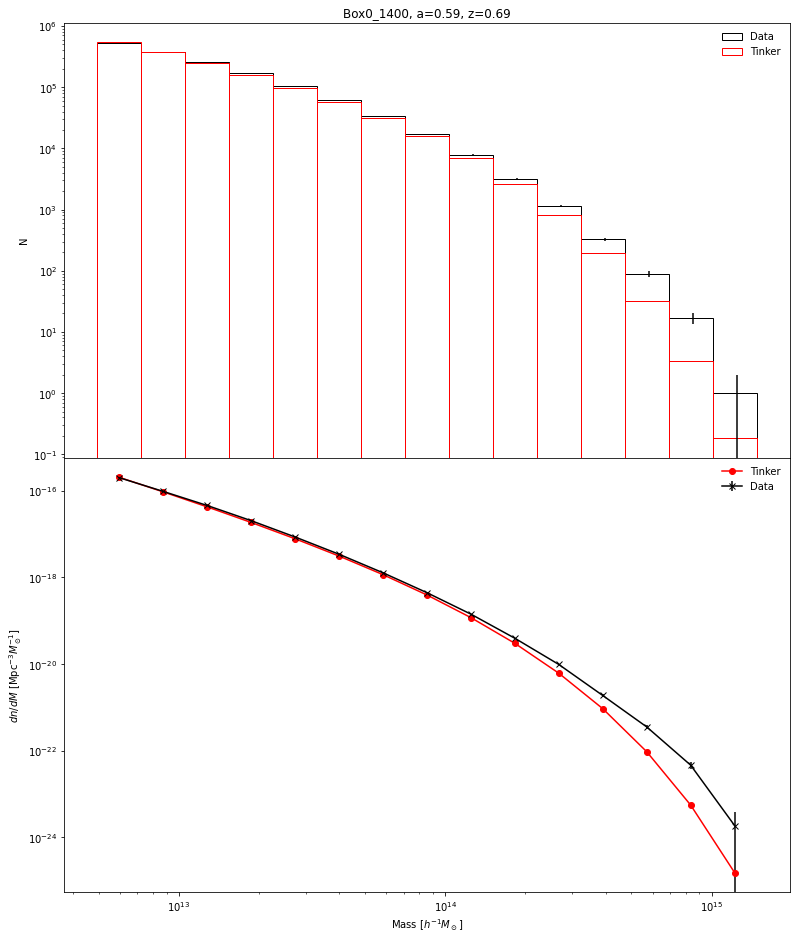

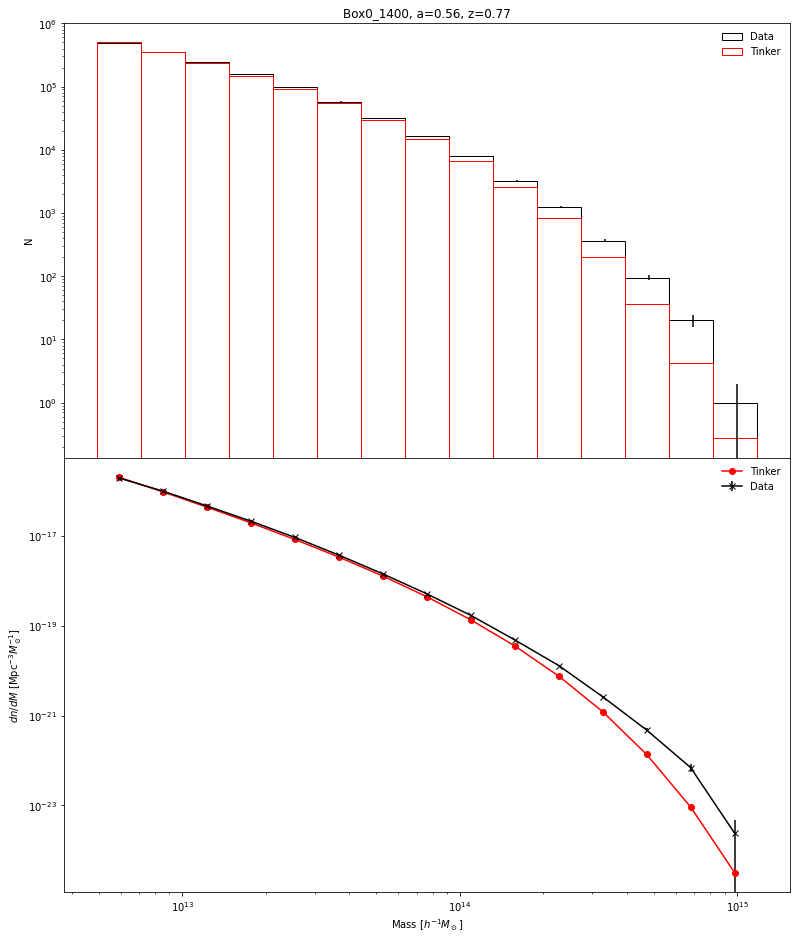

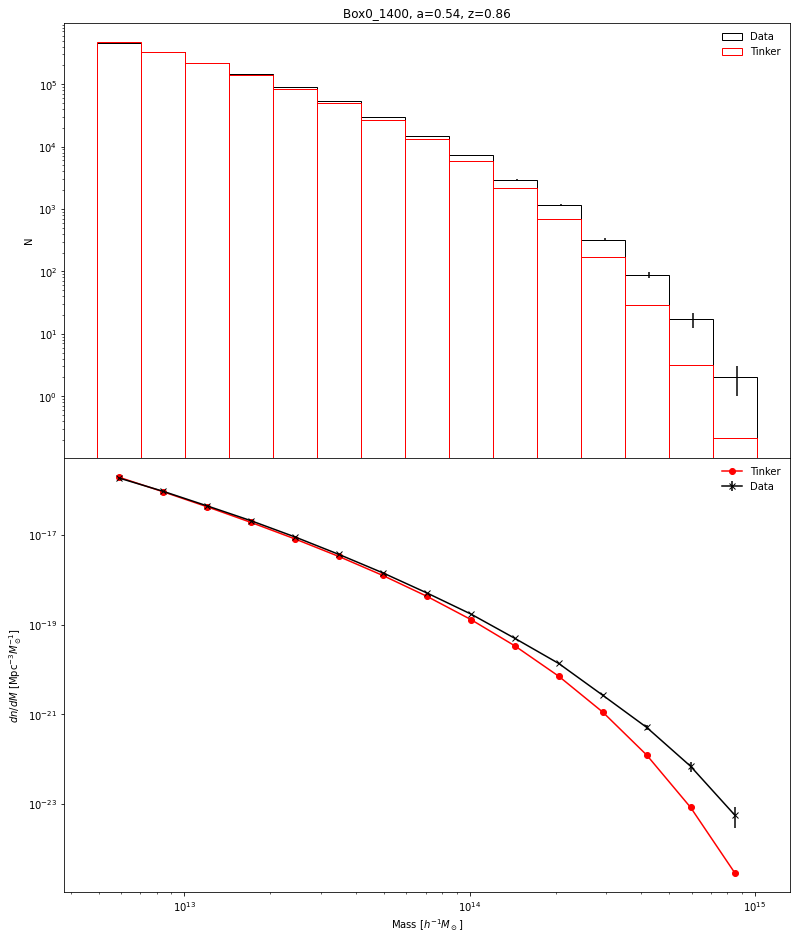

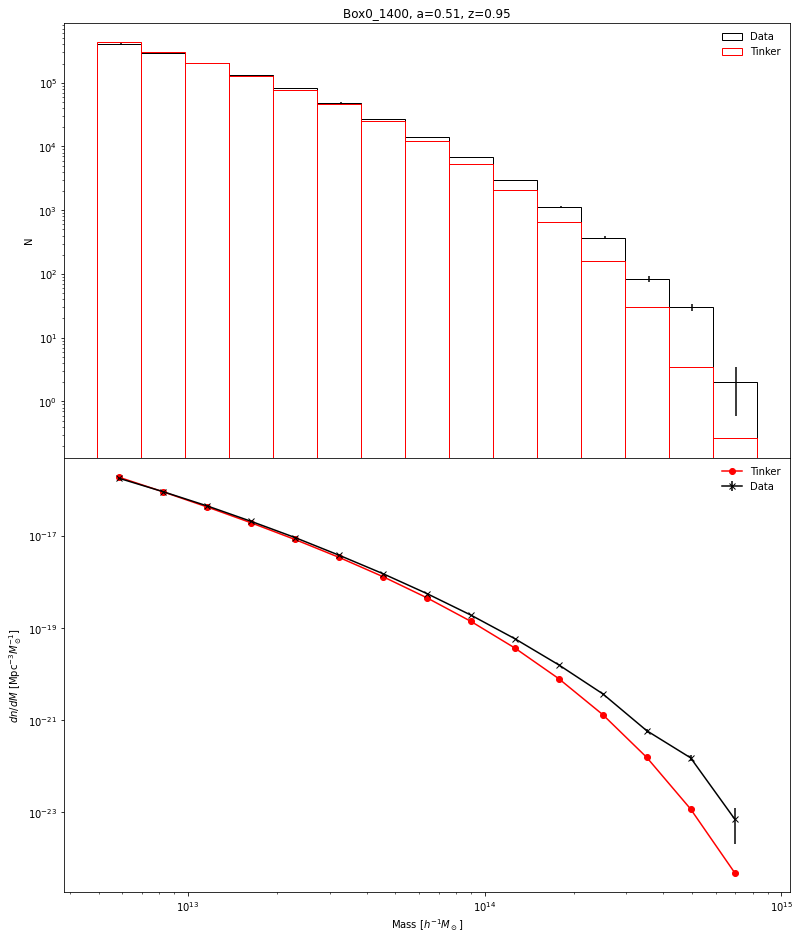

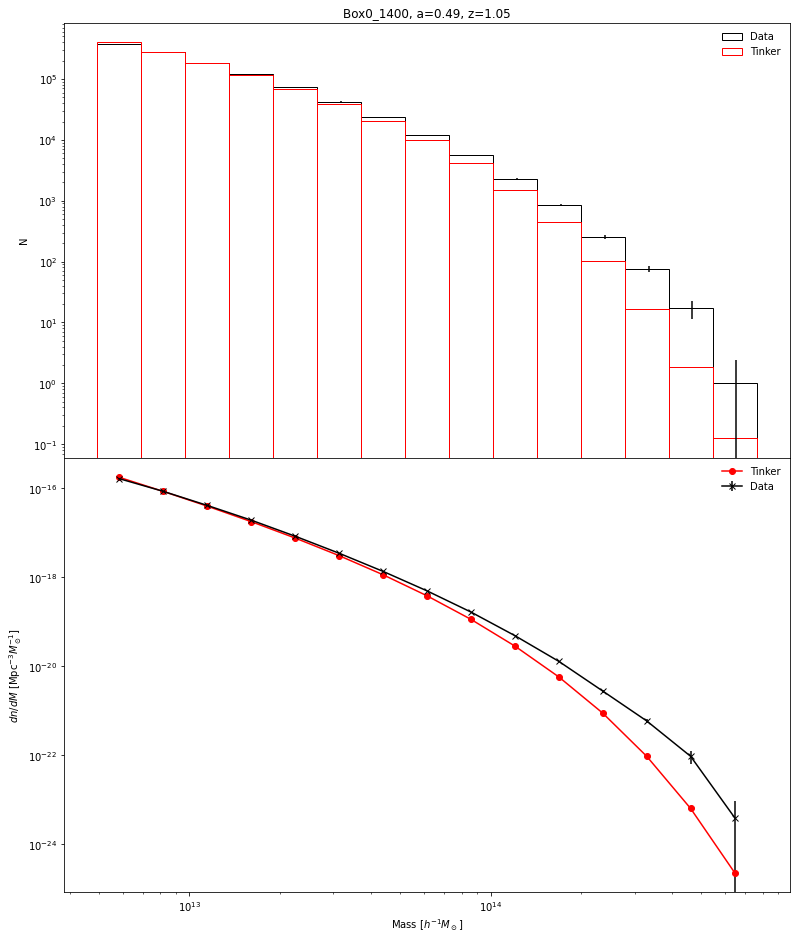

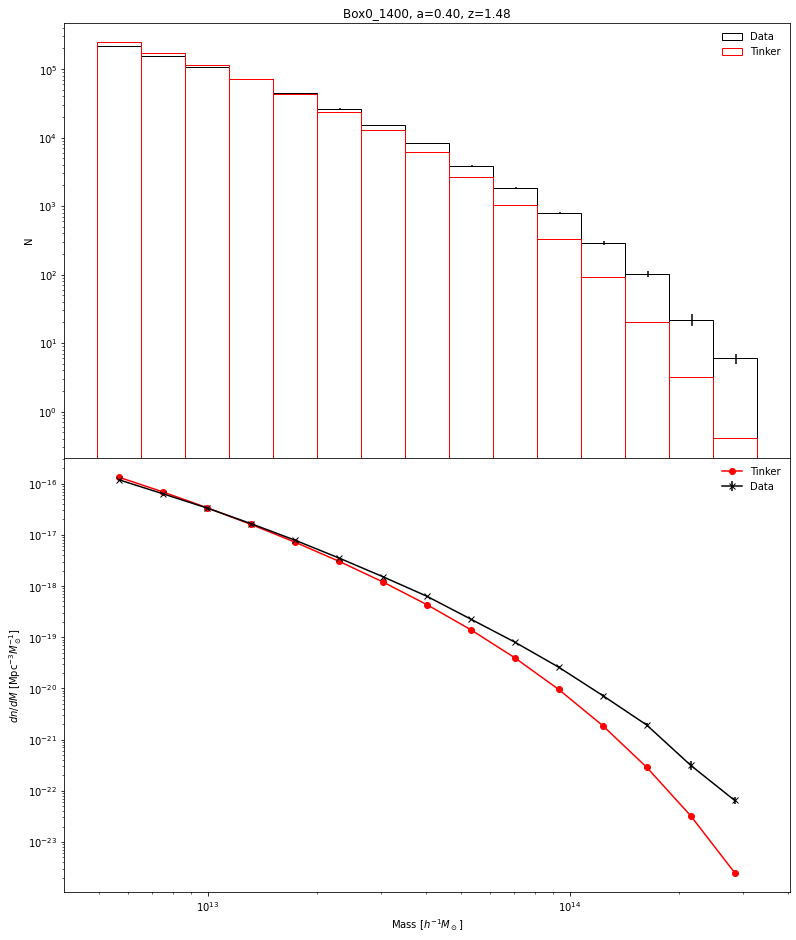

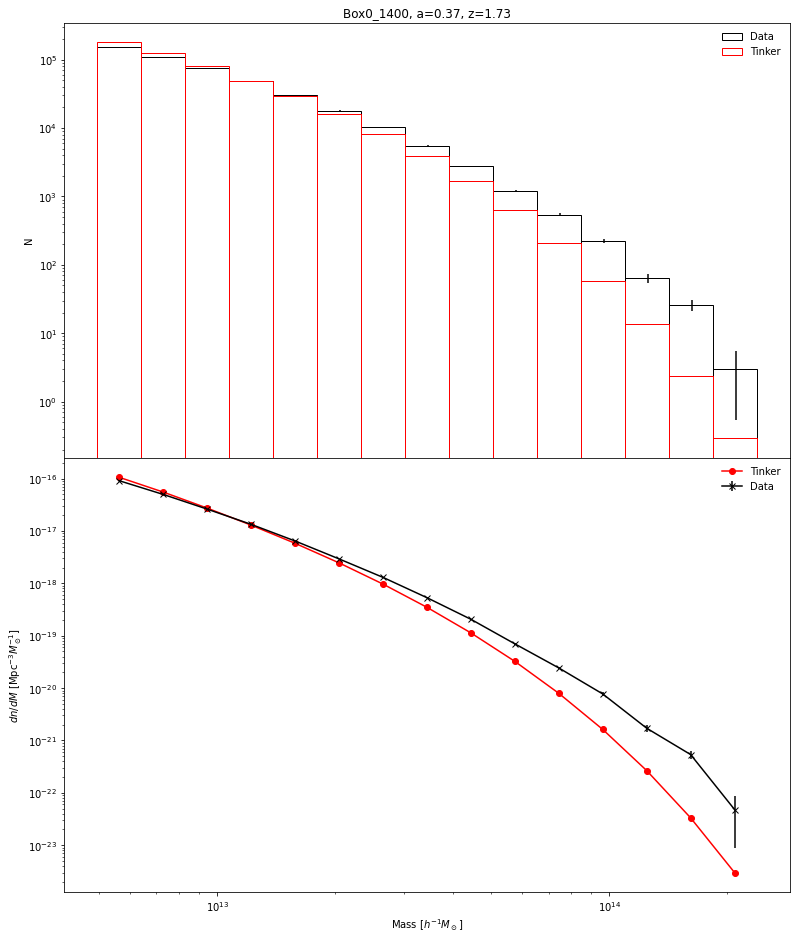

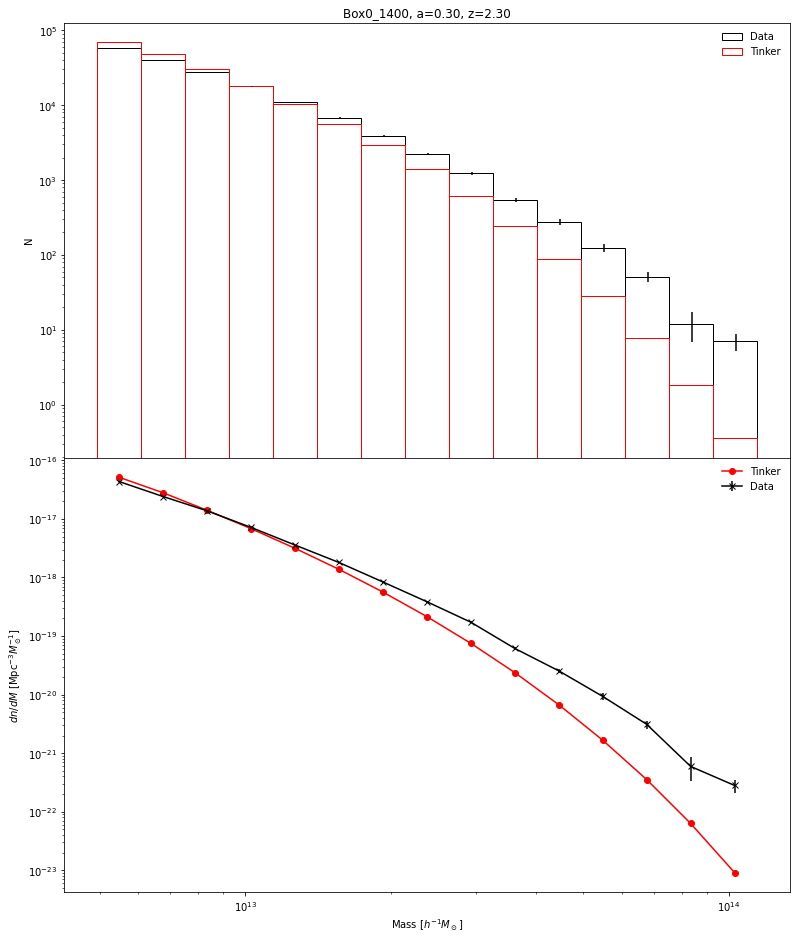

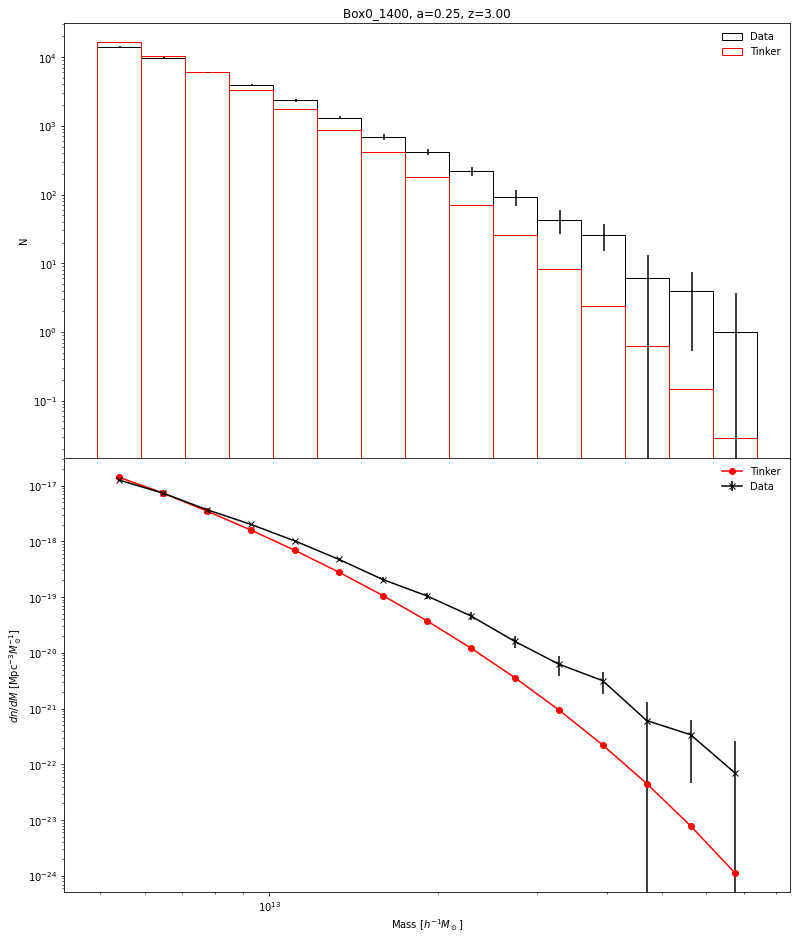

In [14]:
MLE_params = dict(zip(param_names, result['x']))

from scipy.interpolate import interp1d
i=0
for a in reversed(a_to_z):
    z = a_to_z[a]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (N/vol)/dM

    tinker_eval = [tinker(a, M_c,**MLE_params) for M_c in Ms]
    
    yerr = np.array( [jackknife[a][1][i][i]+poisson_err[i]**2 for i in range(len(jackknife[a][1]))])
    yerr = np.sqrt(yerr)


    axs[1].errorbar(Ms, dndM, fmt='x-',yerr=yerr/vol/dM, color='black', label='Data')
    axs[1].plot(Ms, tinker_eval, 'o-', color='red', label='Tinker')



    tinker_eval = [tinker(a, M_c,**MLE_params,)*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    edge_centers = [np.sqrt(edge[0]*edge[1]) for edge in edge_pairs]
    
#     axs[0].scatter(Ms, N, s=50, marker='x', c='black')
#     axs[0].scatter(edge_centers, tinker_eval, s=50 , marker='o', c='red')
    
    poisson_err = np.sqrt(N)


    assert(len(yerr) == len(N))
#     print(list(zip(yerr/N)))
#     print(np.shape(yerr))
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges), 
               yerr = yerr,
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=tinker_eval, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a,z))
    i+=1
    plt.savefig('figures/%s_MLFits_a%.2f.pdf'%(box, a), bbox_inches='tight')
